In [ ]:
!pip install d2l==0.17.2

     |████████████████████████████████| 82 kB 631 kB/s 
     |████████████████████████████████| 11.6 MB 11.1 MB/s 
     |████████████████████████████████| 9.9 MB 16.8 MB/s 
     |████████████████████████████████| 20.1 MB 1.5 MB/s 
     |████████████████████████████████| 61 kB 7.3 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the p

In this section, we will introduce GoogLeNet, presenting a slightly simplified version of the original model.

##Inception Blocks
The basic convolutional block in GoogLeNet is called an Inception block, likely named due to a quote from the movie Inception (“We need to go deeper”).

![Structure of the Inception block.](http://d2l.ai/_images/inception.svg)
Structure of the Inception block

the inception block consists of four parallel paths. The first three paths use convolutional layers with window sizes of  1×1 ,  3×3 , and  5×5  to extract information from different spatial sizes. The middle two paths perform a  1×1  convolution on the input to reduce the number of channels, reducing the model’s complexity. The fourth path uses a  3×3  maximum pooling layer, followed by a  1×1  convolutional layer to change the number of channels. The four paths all use appropriate padding to give the input and output the same height and width.



In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class Inception(nn.Module):
    # `c1`--`c4` are the number of output channels for each path
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Path 1 is a single 1 x 1 convolutional layer
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # Path 2 is a 1 x 1 convolutional layer followed by a 3 x 3
        # convolutional layer
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # Path 3 is a 1 x 1 convolutional layer followed by a 5 x 5
        # convolutional layer
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # Path 4 is a 3 x 3 maximum pooling layer followed by a 1 x 1
        # convolutional layer
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # Concatenate the outputs on the channel dimension
        return torch.cat((p1, p2, p3, p4), dim=1)

##GoogLeNet Model
GoogLeNet uses a stack of a total of 9 inception blocks and global average pooling to generate its estimates. Maximum pooling between inception blocks reduces the dimensionality.

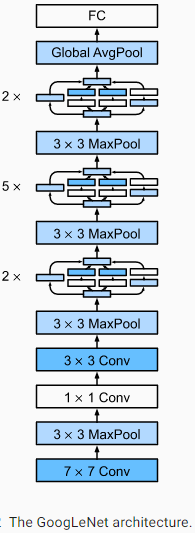

We can now implement GoogLeNet piece by piece. The first module uses a 64-channel  7×7  convolutional layer.

In [ ]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

The second module uses two convolutional layers: first, a 64-channel  1×1  convolutional layer, then a  3×3  convolutional layer that triples the number of channels. This corresponds to the second path in the Inception block.

In [ ]:
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

The third module connects two complete Inception blocks in series

In [ ]:
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

The fourth module is more complicated. It connects five Inception blocks in series.

In [ ]:
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

The fifth module has two Inception blocks. Finally, we turn the output into a two-dimensional array followed by a fully-connected layer whose number of outputs is the number of label classes.

In [ ]:
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

The GoogLeNet model is computationally complex, so it is not as easy to modify the number of channels as in VGG. To have a reasonable training time on Fashion-MNIST, we reduce the input height and width from 224 to 96. This simplifies the computation. The changes in the shape of the output between the various modules are demonstrated below.

In [ ]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


##Training
As before, we train our model using the Fashion-MNIST dataset. We transform it to  96×96  pixel resolution before invoking the training procedure.


In [ ]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

<Figure size 252x180 with 1 Axes>

##Summary
The Inception block is equivalent to a subnetwork with four paths. It extracts information in parallel through convolutional layers of different window shapes and maximum pooling layers.  1×1  convolutions reduce channel dimensionality on a per-pixel level. Maximum pooling reduces the resolution.

GoogLeNet connects multiple well-designed Inception blocks with other layers in series. The ratio of the number of channels assigned in the Inception block is obtained through a large number of experiments on the ImageNet dataset.

GoogLeNet, as well as its succeeding versions, was one of the most efficient models on ImageNet, providing similar test accuracy with lower computational complexity.